## Extract image features from a patch

In [1]:
import numpy as np
import scipy.io as io
import h5py
import deepdish as dd
import dask.array as da
import os

import skimage
from skimage import io, color
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
h5path = '../../H5data/M2'
fname = os.listdir(h5path)
thisfile = fname[2]
print fname

['Bo130828_s92a_v4fv_orig_0005_nev.h5', 'Bo130828_s92a_v4fv_orig_0006_nev.h5', 'Bo130828_s92a_v4fv_orig_0007_nev.h5', 'Bo130828_s92a_v4fv_orig_0008_nev.h5', 'Bo130829_s93a_v4fv_eqlum_0004_nev.h5', 'Bo130829_s94a_v4fv_randlum_0005_nev.h5', 'Bo130829_s94a_v4fv_randlum_0006_nev.h5']


### Read in using deepdish

In [3]:
### Read in using deepdish
dat = dd.io.load(h5path+'/'+thisfile)

### Manipulate spike data

In [4]:
## Show first ten spike times for unit 5401
dat['spikes']['5401'][:10]

array([ 0.0134    ,  0.04193333,  0.0593    ,  0.12966667,  0.3099    ,
        0.32123333,  0.37343333,  0.38876667,  0.40143333,  0.42673333])

In [5]:
dat['eyes'][0]['impath']

'stimuli/M2/Orig'

### Manipulate image data

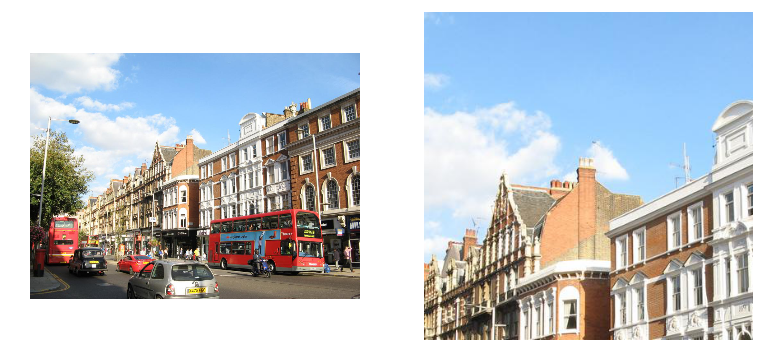

In [6]:
# Extract a patch of arbitrary radius around a fixation
projectpath = '../..'
fx = 65

# Read in the image
impath = dat['eyes'][fx]['impath']
imname = dat['eyes'][fx]['imname']
filename = projectpath+'/'+impath+'/'+imname
I = io.imread(filename)

# Pad the image
[H,W,D] = I.shape
I_pad = 128*np.ones([3*H, 3*W, D])
I_pad[H-1:2*H-1,W-1:2*W-1,0] = I[:,:,0]
I_pad[H-1:2*H-1,W-1:2*W-1,1] = I[:,:,1]
I_pad[H-1:2*H-1,W-1:2*W-1,2] = I[:,:,2]

# Get gaze location
r = int(dat['eyes'][fx]['row'])
c = int(dat['eyes'][fx]['col'])

# If gaze is within the image borders
if(r>0 and r<768 and c>0 and c<1024):
    # Extract patch
    R = 200 #radius
    G = np.zeros([2*R, 2*R, 3])
    G = I_pad[r+H-R:r+H+R, c+W-R:c+W+R, :]
    
    # Show patch
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(I)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(np.uint8(G))
    plt.axis('off')
    plt.show()
    
    # Extract hsl features
else:
    print r,c
    print 'outside'

In [169]:
imtest = np.zeros([2,2,3])
imtest[0,0,:] = [0.1, 0.2, 0.3]
imtest[0,1,:] = [0.3, 0.2, 0.1]
imtest[1,0,:] = [0.3, 0.2, 0.1]
imtest[1,1,:] = [0.3, 0.2, 0.1]
%timeit color.rgb2luv(imtest)
%timeit color.rgb2hsv(imtest)

The slowest run took 4.06 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 136 µs per loop
10000 loops, best of 3: 110 µs per loop


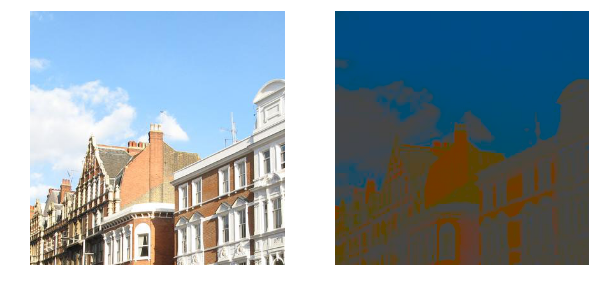

In [188]:
# Convert to Luv
Luv = color.rgb2luv(G/255.0)

# Extract hue
hue = np.arctan2(Luv[:,:,2], Luv[:,:,1])

# Assign lum channel to a constant
Luv[:,:,0] = 30.0*np.ones([Luv.shape[0], Luv.shape[1]])

# Convert back to RGB just to visualize
Gviz = color.luv2rgb(Luv)

# Show images
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(np.uint8(G))
plt.axis('off')

plt.subplot(122)
plt.imshow(np.uint8(255.0*Gviz))
plt.axis('off')
plt.show()


In [189]:
import pycircstat as pyc
from scipy import stats

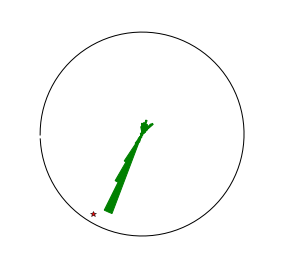

In [192]:
# Compute histogram and circular mean of hue
Nbins=100
huehist, bin_edges = np.histogram(hue, bins=Nbins)
plt.figure()
ax = plt.subplot(111, polar=True)
ax.bar(bin_edges[:Nbins]+(bin_edges[1]-bin_edges[0])/2, huehist, width=0.1, edgecolor='g', color='g')
ax.hold
ax.plot(bin_edges+(bin_edges[1]-bin_edges[0])/2, 1.2*np.max(huehist)*np.ones(len(huehist)+1), color='k')

mean_hue = stats.circmean(hue, high=np.pi, low=-np.pi)
ax.plot(mean_hue, 1.1*np.max(huehist), 'r*')

plt.axis('off')
plt.show()
